In [ ]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow

In [ ]:
# Code from https://www.andreasjakl.com/understand-and-apply-stereo-rectification-for-depth-maps-part-2/

imgR = cv.imread('1img_r.jpeg', cv.IMREAD_GRAYSCALE)
imgL = cv.imread('1img_l.jpeg', cv.IMREAD_GRAYSCALE)

In [ ]:
sift = cv.SIFT_create()
kp1, des1 = sift.detectAndCompute(imgL, None)
kp2, des2 = sift.detectAndCompute(imgR, None)

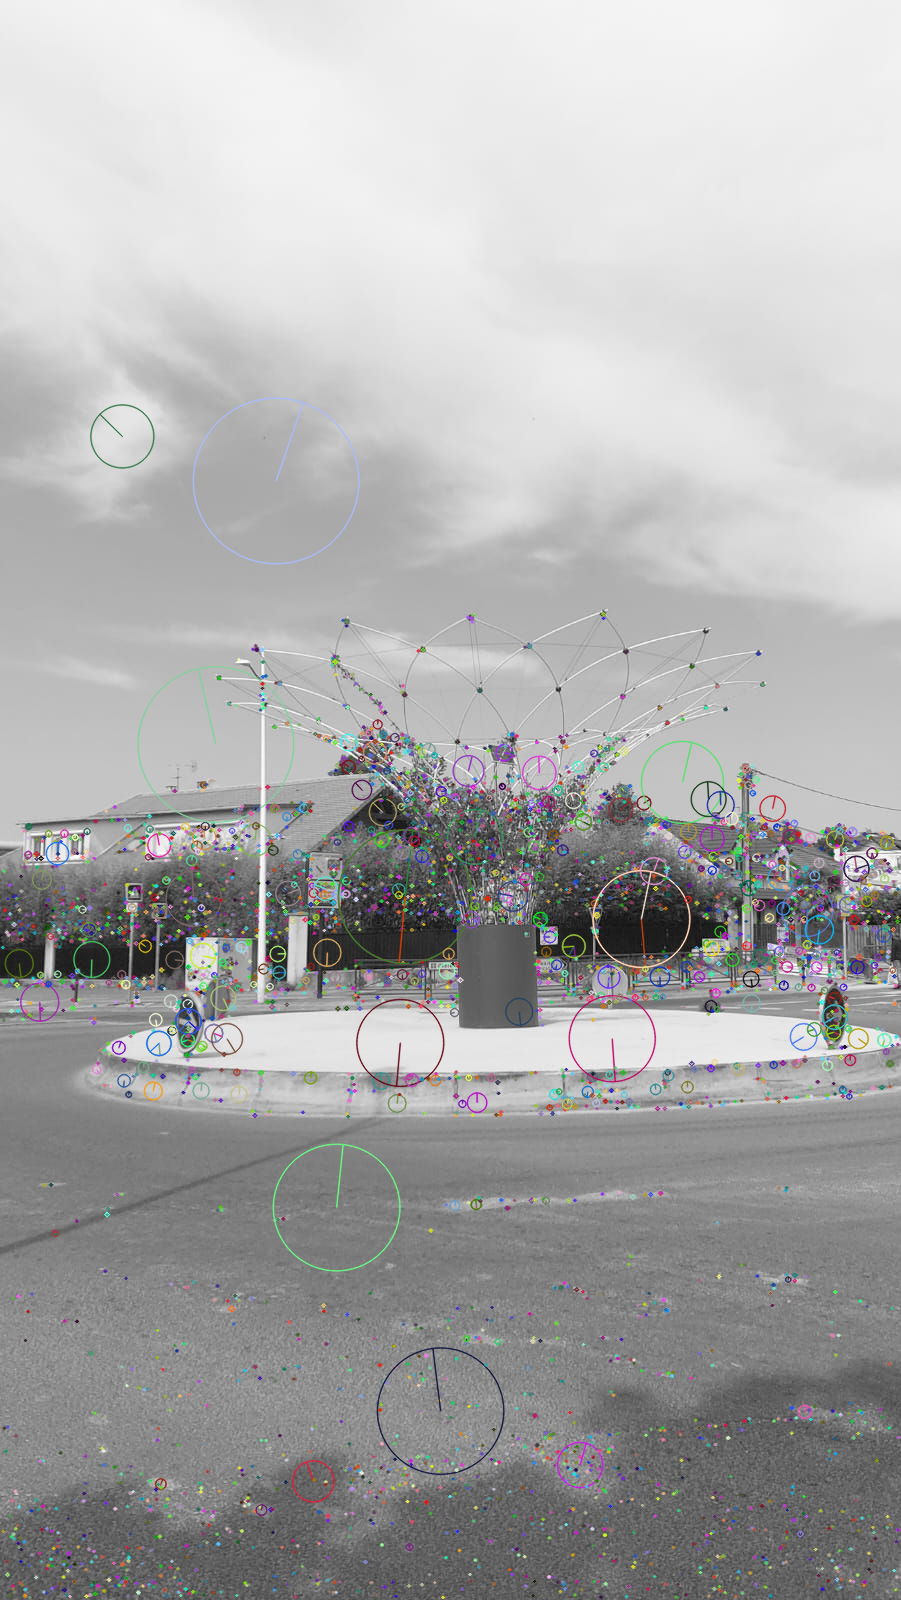

In [ ]:
imgSift = cv.drawKeypoints(
    imgL, kp1, None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv2_imshow(imgSift)

In [ ]:
# Match keypoints in both images
# Based on: https://docs.opencv.org/master/dc/dc3/tutorial_py_matcher.html
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)   # or pass empty dictionary
flann = cv.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

# Keep good matches: calculate distinctive image features
# Lowe, D.G. Distinctive Image Features from Scale-Invariant Keypoints. International Journal of Computer Vision 60, 91–110 (2004). https://doi.org/10.1023/B:VISI.0000029664.99615.94
# https://www.cs.ubc.ca/~lowe/papers/ijcv04.pdf
matchesMask = [[0, 0] for i in range(len(matches))]
good = []
pts1 = []
pts2 = []

for i, (m, n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        # Keep this keypoint pair
        matchesMask[i] = [1, 0]
        good.append(m)
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)

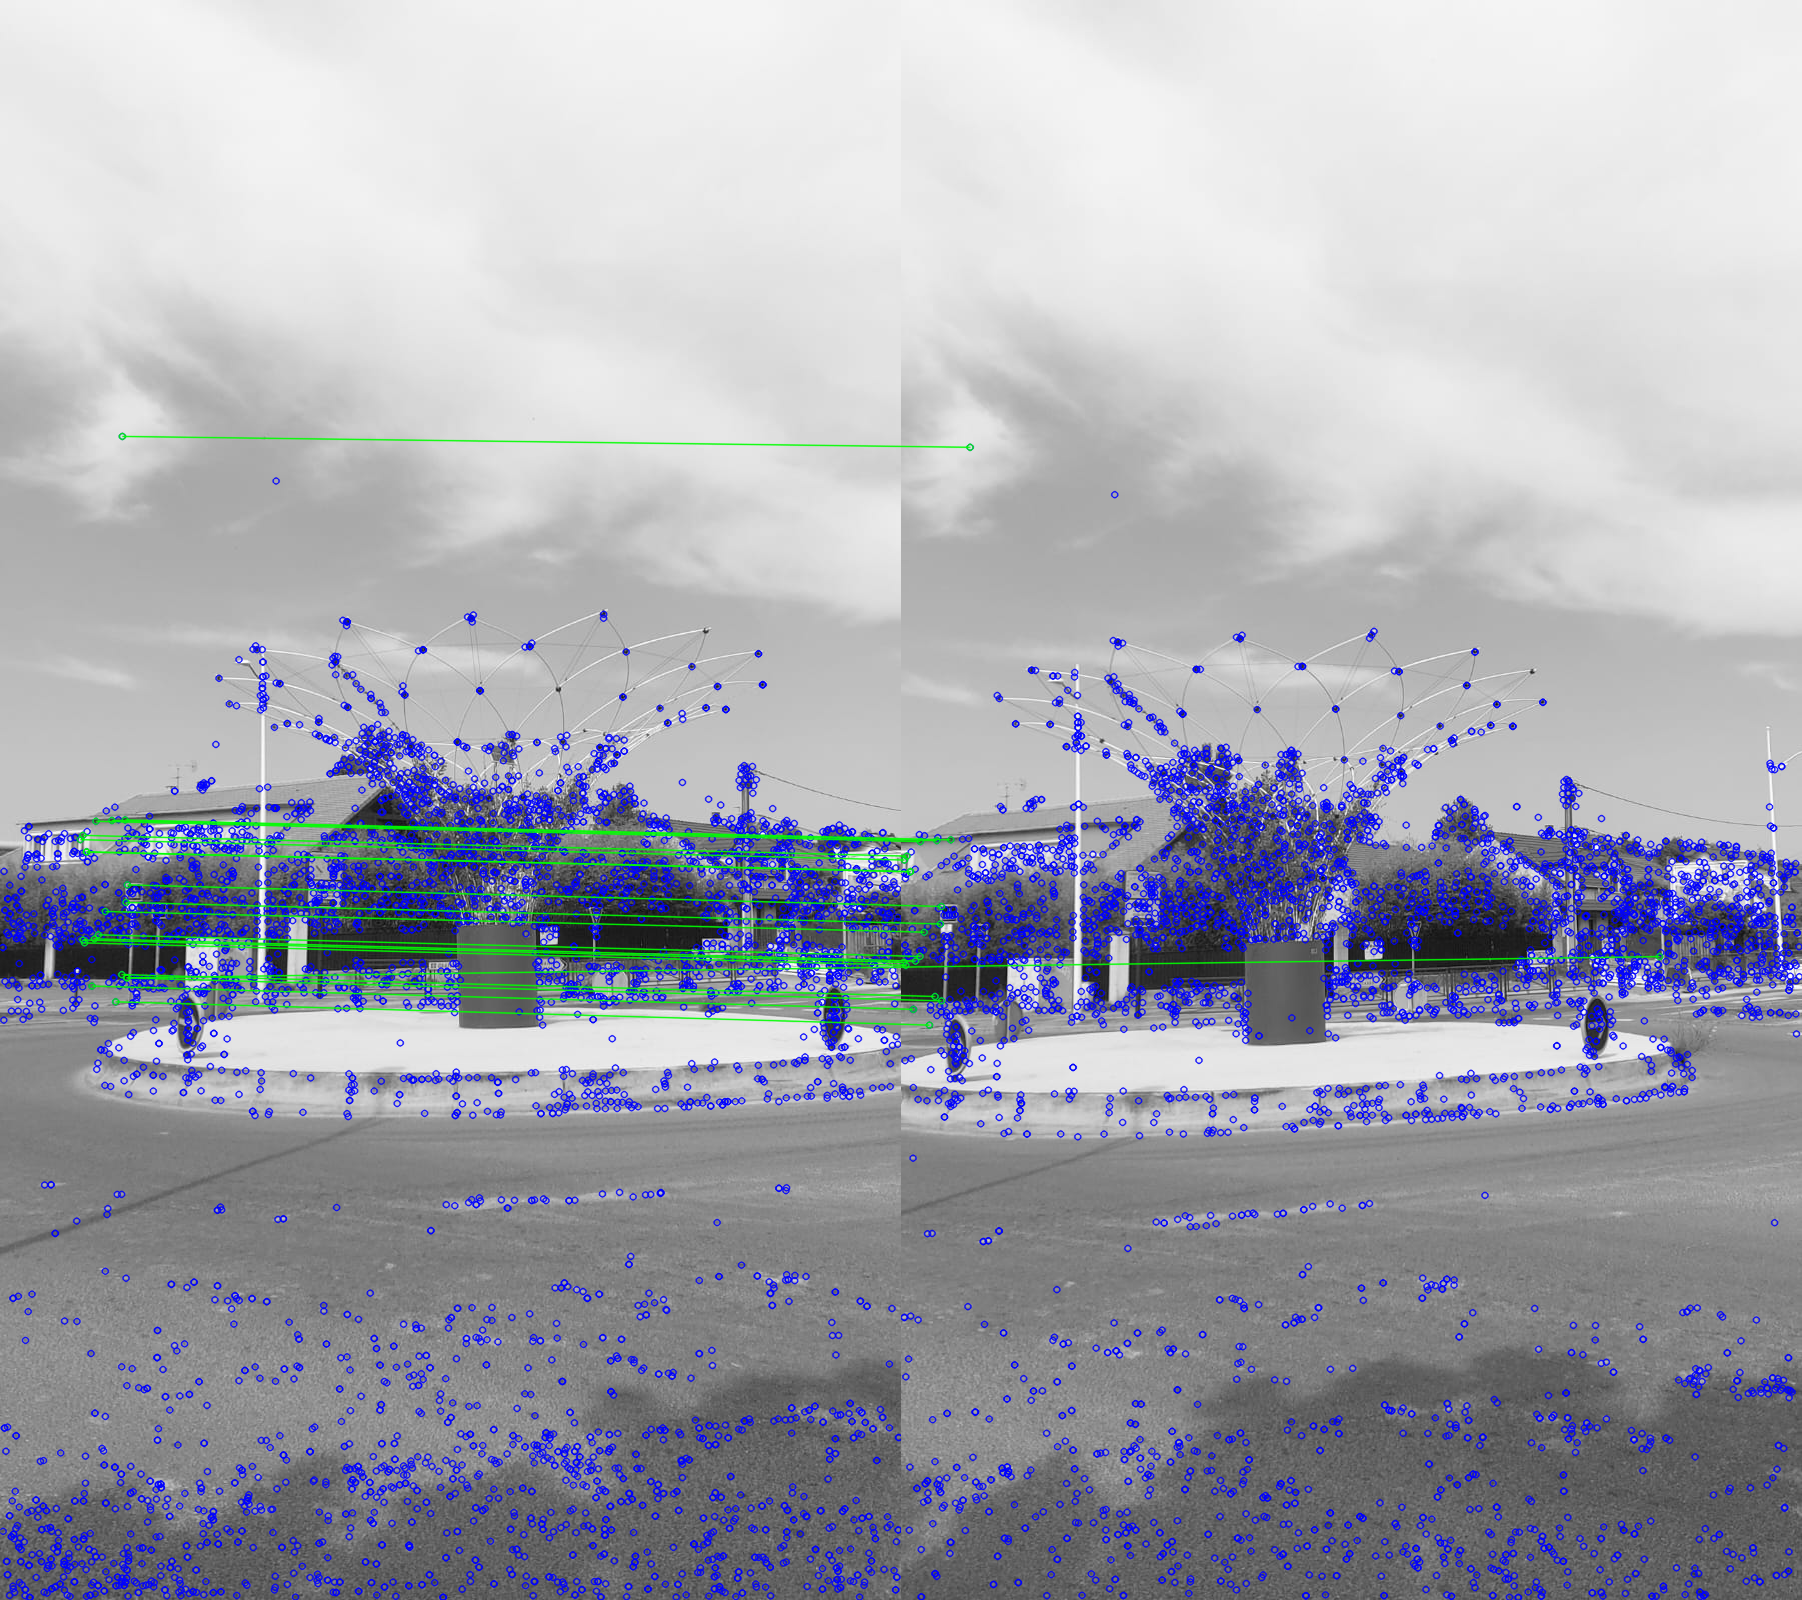

In [ ]:
draw_params = dict(matchColor=(0, 255, 0),
                   singlePointColor=(255, 0, 0),
                   matchesMask=matchesMask[300:500],
                   flags=cv.DrawMatchesFlags_DEFAULT)

keypoint_matches = cv.drawMatchesKnn(
    imgL, kp1, imgR, kp2, matches[300:500], None, **draw_params)
cv2_imshow(keypoint_matches)

In [ ]:
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
fundamental_matrix, inliers = cv.findFundamentalMat(pts1, pts2, cv.FM_RANSAC)

# We select only inlier points
pts1 = pts1[inliers.ravel() == 1]
pts2 = pts2[inliers.ravel() == 1]

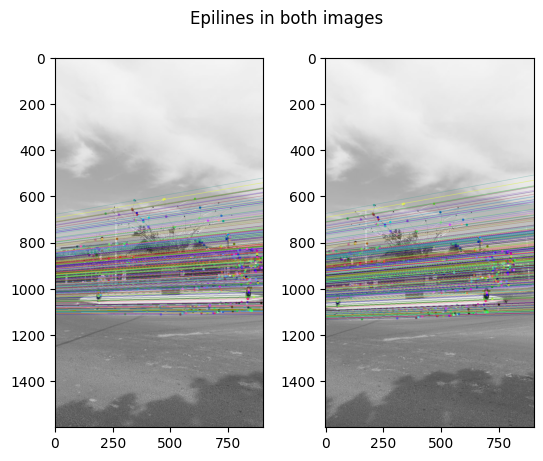

In [ ]:
# Visualize epilines
# Adapted from: https://docs.opencv.org/master/da/de9/tutorial_py_epipolar_geometry.html
def drawlines(img1src, img2src, lines, pts1src, pts2src):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r, c = img1src.shape
    img1color = cv.cvtColor(img1src, cv.COLOR_GRAY2BGR)
    img2color = cv.cvtColor(img2src, cv.COLOR_GRAY2BGR)
    # Edit: use the same random seed so that two images are comparable!
    np.random.seed(0)
    for r, pt1, pt2 in zip(lines, pts1src, pts2src):
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2]/r[1]])
        x1, y1 = map(int, [c, -(r[2]+r[0]*c)/r[1]])
        img1color = cv.line(img1color, (x0, y0), (x1, y1), color, 1)
        img1color = cv.circle(img1color, tuple(pt1), 5, color, -1)
        img2color = cv.circle(img2color, tuple(pt2), 5, color, -1)
    return img1color, img2color


# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv.computeCorrespondEpilines(
    pts2.reshape(-1, 1, 2), 2, fundamental_matrix)
lines1 = lines1.reshape(-1, 3)
img5, img6 = drawlines(imgL, imgR, lines1, pts1, pts2)

# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv.computeCorrespondEpilines(
    pts1.reshape(-1, 1, 2), 1, fundamental_matrix)
lines2 = lines2.reshape(-1, 3)
img3, img4 = drawlines(imgR, imgL, lines2, pts2, pts1)

plt.subplot(121), plt.imshow(img5)
plt.subplot(122), plt.imshow(img3)
plt.suptitle("Epilines in both images")
plt.show()

In [ ]:
# Stereo rectification (uncalibrated variant)
# Adapted from: https://stackoverflow.com/a/62607343
h1, w1 = imgL.shape
h2, w2 = imgR.shape
_, H1, H2 = cv.stereoRectifyUncalibrated(
    np.float32(pts1), np.float32(pts2), fundamental_matrix, imgSize=(w1, h1)
)

In [ ]:
# Undistort (rectify) the images and save them
# Adapted from: https://stackoverflow.com/a/62607343
img1_rectified = cv.warpPerspective(imgL, H1, (w1, h1))
img2_rectified = cv.warpPerspective(imgR, H2, (w2, h2))
cv.imwrite("rectified_1.png", img1_rectified)
cv.imwrite("rectified_2.png", img2_rectified)

True

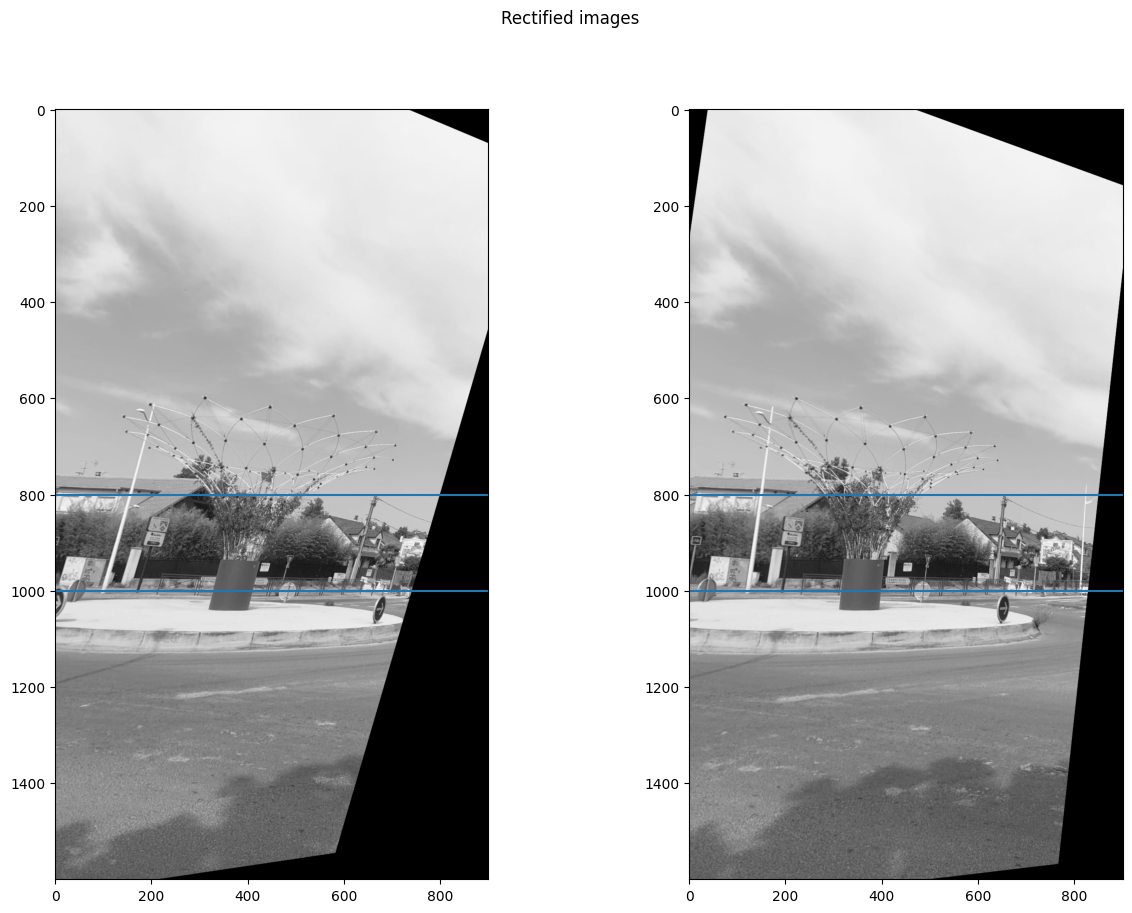

In [ ]:
# Draw the rectified images
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
axes[0].imshow(img1_rectified, cmap="gray")
axes[1].imshow(img2_rectified, cmap="gray")
axes[0].axhline(800)
axes[1].axhline(800)
axes[0].axhline(1000)
axes[1].axhline(1000)
plt.suptitle("Rectified images")
plt.savefig("rectified_images.png")
plt.show()

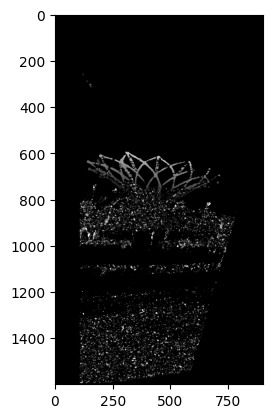

In [ ]:

# creates StereoBm object 
stereo = cv.StereoBM_create(numDisparities = 16*4,
                            blockSize = 9)

stereo.setTextureThreshold(1000)
stereo.setMinDisparity(40)

# computes disparity
disparity = stereo.compute(img1_rectified, img2_rectified)

#fig, axis = plt.subplots(1,3)
#axis[0].imshow(img1_rectified, 'gray')
#axis[1].imshow(img2_rectified, 'gray')
#axis[2].imshow(disparity, 'gray')
plt.imshow(disparity, 'gray')
plt.savefig("disparity_stereo.png")
plt.show()